**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andr√©s (gonzalo.marcosa@um.es)
- Francisco Jos√© L√≥pez Fern√°ndez (franciscojose.lopezf@um.es)

**M√°ster de Inteligencia Artificial**

| **Facultad de Inform√°tica** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# **Pr√°ctica 2.  Aprendizaje en entornos complejos**

## **1. Preparaci√≥n del Entorno**

### 1.1 Introducci√≥n.  

Este notebook se enfoca en la implementaci√≥n y an√°lisis de un agente que utiliza **Aprendizaje por Refuerzo** para resolver distintos entornos que nos ofrece `gymnasium`.  

Los entornos que vamos a utlizar son: 

 - **FrozenLake (4x4)**

 - **FrozenLake (8x8)**

### 1.2. Instalaci√≥n de Dependencias

Se instalan las librer√≠as necesarias para trabajar con el entorno de simulaci√≥n `gymnasium`, lo que permite crear un ambiente controlado donde el agente pueda interactuar y aprender. Este entorno simula una cuadr√≠cula donde el agente debe navegar para alcanzar una meta, mientras se enfrenta a varios desaf√≠os.

In [40]:
%%capture
# ! pip install 'gym[box2d]==0.20.0'
# ! pip install gymnasium[box2d]
# ! pip install "gymnasium[toy-text]
# ! pip install gymnasium 
# ! pip install numpy
# ! pip install matplotlib
# ! pip install tqdm
# ! pip install torch

### 1.3 Librer√≠as

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random

from src_agents import *
from src_plotting import *

### 1.4 Importaci√≥n de los Entornos 

Se cargan dos entornos diferentes para el agente:
- **FrozenLake (4x4)** es un peque√±o lago congelado en el que el agente debe navegar para llegar a su destino, evitando caer en el agua. Este entorno es especialmente √∫til para un aprendizaje inicial, ya que no es resbaladizo, lo que facilita la comprensi√≥n de c√≥mo el agente interact√∫a con el entorno.

- **CliffWalking** el agente aqu√≠ debe caminar a lo largo de un acantilado, evitando caer en √©l. Este entorno introduce m√°s complejidad, ya que las acciones del agente tienen consecuencias m√°s dram√°ticas, como caer en el acantilado si no se tiene cuidado, lo que ofrece una mayor oportunidad para evaluar la capacidad del agente de aprender de los castigos y recompensas.



### 1.5 Funciones para Mostrar los Resultados
Se definen varias funciones para graficar y visualizar los resultados del entrenamiento del agente. Estas funciones permiten analizar el desempe√±o del agente en diferentes aspectos.
1.`plot(list_stats)`  
   - **Descripci√≥n**: Graficar√° la proporci√≥n de recompensas obtenidas en cada episodio del entrenamiento. Este gr√°fico proporciona una visualizaci√≥n clara del progreso del agente, mostrando c√≥mo mejora su desempe√±o a medida que avanza en el proceso de aprendizaje.

2. `plot_episode_lengths(episode_lengths, window=50)`  
   - **Descripci√≥n**: Graficar√° la longitud de los episodios en el entrenamiento, y calcular√° y mostrar√° la tendencia de las longitudes utilizando una media m√≥vil.

3. `plot_policy_blank(Q, env)`  
   - **Descripci√≥n**: Dibuja la pol√≠tica aprendida por el agente sobre un entorno vac√≠o, representando las acciones √≥ptimas en cada estado de la **Q-table** del agente con flechas (izquierda, abajo, derecha, arriba).

4. `plot_comparison(stats_list, labels, title="Comparaci√≥n de Resultados de Entrenamiento")`  
   - **Descripci√≥n**: Compara la evoluci√≥n de las recompensas obtenidas por diferentes algoritmos o agentes a lo largo del entrenamiento, permitiendo visualizar el rendimiento relativo de cada uno.

5. `plot_episode_lengths_comparison(episode_lengths_list, labels, window=50, title="Comparaci√≥n de Longitudes de Episodios")`  
   - **Descripci√≥n**: Compara las longitudes de los episodios de diferentes agentes, mostrando las longitudes y las tendencias de cada uno en subgr√°ficas separadas, con sombreado y media m√≥vil.

Todas las funciones y clases relacionadas con la visualizaci√≥n de gr√°ficos se encuentran en el archivo `src_agents/plotting.py`. Para utilizarlas, ser√° necesario importar las librer√≠as correspondientes desde esa ruta.

## **2. Dise√±o del Agente**

### 2.1 Estructura del Agente

Este es la estructura que contiene la implementaci√≥n de distintos agentes, organizados en m√≥dulos espec√≠ficos para facilitar su uso y mantenimiento.  

Cada agente hereda de una clase base (`agent.py`) y utiliza diferentes estrategias de aprendizaje, como **Monte Carlo**, **Q-Learning** y **SARSA**. Adem√°s, se incluyen m√≥dulos auxiliares para definir pol√≠ticas de exploraci√≥n y visualizar resultados.

```plaintext
|-- üìÇ src_agents                  # Carpeta principal que contiene los agentes de Aprendizaje por Refuerzo
|   |-- üìÑ __init__.py             # Archivo que convierte el directorio en un paquete de Python
|   |-- üìÑ agent.py                # Clase base para todos los agentes
|   |-- üìÑ monteCarloOnPolicy.py   # Implementaci√≥n del agente Monte Carlo On-Policy
|   |-- üìÑ monteCarloOffPolicy.py  # Implementaci√≥n del agente Monte Carlo Off-Policy
|   |-- üìÑ qLearning.py            # Implementaci√≥n del agente Q-Learning
|   |-- üìÑ sarsa.py                # Implementaci√≥n del agente SARSA
|   |-- üìÑ politicas.py            # Definici√≥n de pol√≠ticas de exploraci√≥n como epsilon-greedy y softmax
|   |-- üìÑ plotting.py             # Funciones de visualizaci√≥n de datos y gr√°ficos


El dise√±o del agente consta de dos partes.  

- Las pol√≠ticas (toma de decisiones) que realiza.
- El algoritmo con el que aprende.

### 2.2 Pol√≠ticas del Agente

- **Epsilon-soft**: Se define una pol√≠tica donde todas las acciones tienen una probabilidad de ser elegida. 
   
- **Pol√≠tica epsilon-greedy**: basada en la pol√≠tica epsilon-soft. De esta forma el agente tiene una peque√±a probabilidad de explorar (tomar una acci√≥n aleatoria) y una mayor probabilidad de explotar (tomar la acci√≥n que considera mejor). Esto permite equilibrar la exploraci√≥n y la explotaci√≥n.  

- **Pol√≠tica greedy**: Es la usada una vez que "ha aprendido".  

### 2.3 Algoritmos


- **Tabulares**  
  - Monte Carlo On Policy  
  - Monte Carlo Off Policy  
  - SARSA
  - Q - Learning

- **Control con Aproximaciones**
  - SARSA semigradiente
  - Deep Q - Learning


## **3. Experimentaci√≥n - Frozen Lake**

FrozenLake es un entorno de Aprendizaje por Refuerzo incluido en Gymnasium, en el que un agente debe aprender a desplazarse sobre una superficie helada para llegar a un objetivo sin caer en agujeros. Se representa como una cuadr√≠cula donde cada celda puede ser suelo firme, un agujero o la meta. 

El agente puede moverse en cuatro direcciones: izquierda, derecha, arriba y abajo. En la versi√≥n est√°ndar del entorno, el hielo introduce un factor de aleatoriedad en los movimientos, lo que significa que el agente no siempre se desplaza en la direcci√≥n elegida. Sin embargo, en este caso **configuraremos el entorno sin deslizamiento**, lo que significa que el agente se mover√° exactamente en la direcci√≥n que elija sin desviaciones aleatorias. Esto hace que el problema sea m√°s determinista y permite un aprendizaje m√°s directo de las estrategias √≥ptimas.

El objetivo del agente es llegar a la casilla de meta desde la posici√≥n inicial sin caer en un agujero. Se utiliza un sistema de recompensas en el que el agente recibe una recompensa de 1 cuando alcanza la meta y 0 en cualquier otro caso. Al eliminar el deslizamiento, el agente puede aprender una pol√≠tica √≥ptima de manera m√°s eficiente, ya que sus acciones tienen consecuencias predecibles.

### **3.1 Monte Carlo On-Policy**

Monte Carlo (MC) es un m√©todo de aprendizaje por refuerzo basado en la simulaci√≥n de episodios completos para actualizar la funci√≥n de valor de estado-acci√≥n $Q(s,a)$. En el enfoque **On-Policy**, seguimos una pol√≠tica de exploraci√≥n ($\epsilon$-greedy) y actualizamos $Q$ en funci√≥n de las recompensas obtenidas.

**Caracter√≠sticas clave del m√©todo Monte Carlo On-Policy**:

- Aprende a partir de episodios completos (del estado inicial al terminal).  
- La actualizaci√≥n de $Q(s,a)$ se realiza utilizando el retorno $G$, que es la recompensa acumulada futura descontada:

  $$
  G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T-t-1} R_T
  $$

- Utiliza un promedio incremental para actualizar $Q$, en lugar de una tasa de aprendizaje fija:

  $$
  Q(s,a) \leftarrow Q(s,a) + \frac{1}{N(s,a)} (G - Q(s,a))
  $$

  donde $N(s,a)$ es el n√∫mero de veces que se ha visitado el par $(s,a)$.  
- Sigue una estrategia **On-Policy**, lo que significa que la misma pol√≠tica utilizada para generar episodios tambi√©n se usa para mejorar $Q$.  

**Ecuaci√≥n de actualizaci√≥n de $Q(s,a)$:**
$$
Q(s,a) \leftarrow Q(s,a) + \alpha \cdot (G - Q(s,a))
$$

donde:  
- $G$ es el retorno acumulado desde el estado $s$ y la acci√≥n $a$.  
- $\alpha$ es un promedio incremental basado en el n√∫mero de visitas:  

  $$
  \alpha = \frac{1}{N(s,a)}
  $$

#### 3.1.2 Mapa 8x8

**Implementaci√≥n**  

En primer lugar, establecemos una semilla para la reproducibilidad del problema

In [48]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

Creamos el entorno

In [49]:
# Crear el entorno
env_mc_on_policy8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

Creaci√≥n del Agente

In [50]:
agente_mc_on_policy8x8 = MonteCarloOnPolicy(env_mc_on_policy8x8, epsilon=0.4, gamma=1.0, decay=True, num_episodios=50000)

Realizamos el entrenamiento

In [51]:
Q_mc_on_policy8x8, stats_mc_on_policy8x8, episode_lengths_mc_on_policy8x8 = agente_mc_on_policy8x8.entrenar()

Entrenando: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50000/50000 [00:47<00:00, 1056.68episodio/s]


Evaluaci√≥n de la pol√≠tica

In [52]:
pi_star_mc_on_policy8x8, actions_mc_on_policy8x8 = pi_star_from_Q(env_mc_on_policy8x8, Q_mc_on_policy8x8)

Conclusi√≥n

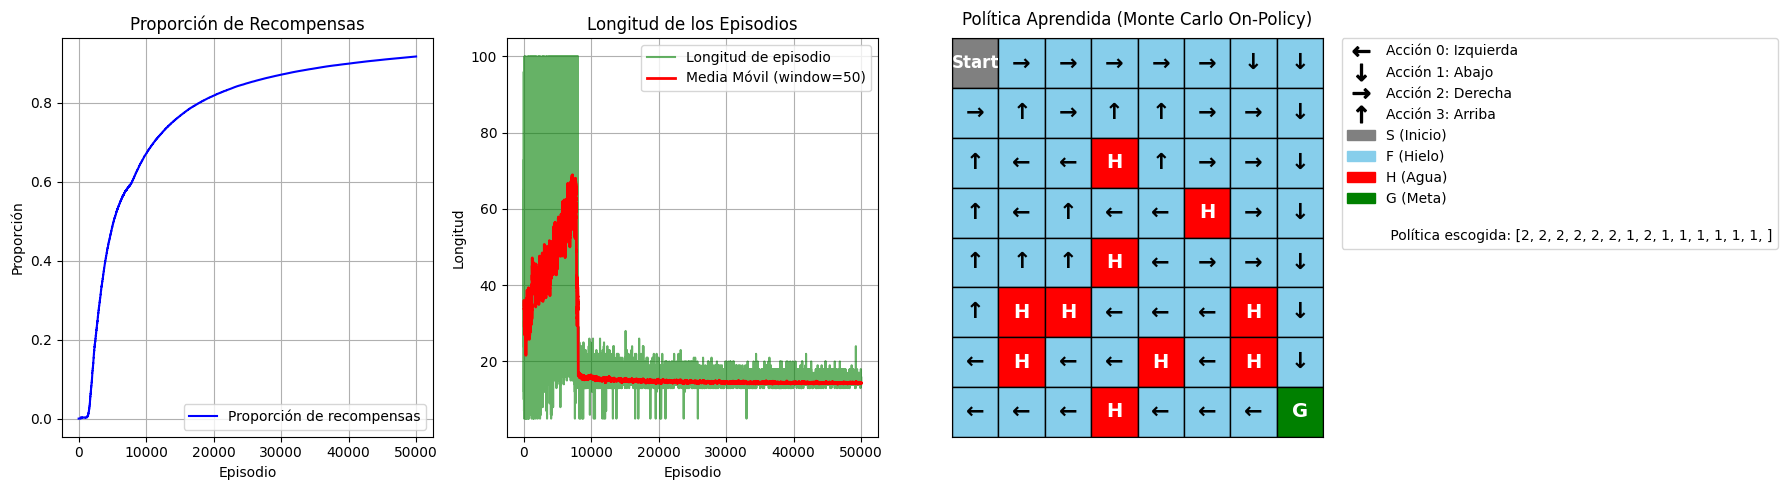

In [53]:
plot_all_three(
    list_stats=stats_mc_on_policy8x8,
    episode_lengths=episode_lengths_mc_on_policy8x8,
    Q=Q_mc_on_policy8x8,
    env=env_mc_on_policy8x8,
    actions=actions_mc_on_policy8x8,
    window=50  # O el valor que quieras
)


### 3.2 Monte Carlo Off-Policy

Monte Carlo (MC) es un m√©todo de aprendizaje por refuerzo basado en la simulaci√≥n de episodios completos para actualizar la funci√≥n de valor de estado-acci√≥n $Q(s,a)$. En la variante **Off-Policy**, la pol√≠tica que se utiliza para generar los episodios (pol√≠tica de comportamiento $b$) puede ser distinta de la pol√≠tica objetivo $\pi$ que deseamos aprender. Para corregir el sesgo introducido por el uso de diferentes pol√≠ticas, se emplea **Weighted Importance Sampling (WIS)**.

Caracter√≠sticas clave del m√©todo Monte Carlo Off-Policy:

- Uso de dos pol√≠ticas:

    - **Pol√≠tica de comportamiento ($b$)**: En este caso, es $\epsilon$-greedy respecto a la Q-table.  
    - **Pol√≠tica objetivo ($\pi$)**: Determinista (greedy) en base a la Q-table.  

- Simulaci√≥n de episodios completos:

Al igual que en Monte Carlo On-Policy, el agente aprende al terminar cada episodio. Sin embargo, las trayectorias se obtienen usando la pol√≠tica de comportamiento $b$.

- Correcci√≥n con Weighted Importance Sampling:

Cada transici√≥n se pondera con un factor de importancia $W$ que mide la raz√≥n entre la probabilidad de la acci√≥n bajo la pol√≠tica objetivo $\pi$ y la probabilidad de la acci√≥n bajo la pol√≠tica de comportamiento $b$. Formalmente:

$$
W \leftarrow W \times \frac{\pi(a_t | s_t)}{b(a_t | s_t)}
$$

Si $\pi(a_t | s_t) = 0$ (es decir, la pol√≠tica objetivo nunca tomar√≠a esa acci√≥n), se corta la retropropagaci√≥n para evitar actualizaciones no representativas.

- Actualizaci√≥n de $Q(s,a)$:

Se realiza de manera incremental, similar al caso On-Policy, pero multiplicando por el factor $W$. Por ejemplo:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha W (G - Q(s,a))
$$

donde $\alpha = \frac{1}{N(s,a)}$ es un promedio incremental basado en el n√∫mero de visitas al par $(s,a)$.


#### 3.2.2 Mapa 8x8

**Implementaci√≥n**

En primer lugar, se establece una semilla para la reproducibilidad y se crea un entorno FrozenLake 8x8 sin deslizamiento (``is_slippery=False``).

In [59]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Creaci√≥n del entorno
env_mc_off_policy8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

A continuaci√≥n, se instancia el agente **MonteCarloOffPolicy**, indicando:

- ``epsilon=0.4``: exploraci√≥n inicial para la pol√≠tica de comportamiento.  

- ``gamma=1.0``: se consideran todas las recompensas futuras sin descuento.  

- ``decay=True``: para reducir ùúñ gradualmente.  

- ``num_episodios=50000``: un n√∫mero grande de episodios para asegurar la convergencia.  

In [60]:
agente_mc_off_policy8x8 = MonteCarloOffPolicy(env_mc_off_policy8x8, decay=True, num_episodios=100000)

El m√©todo `entrenar()` genera episodios siguiendo la pol√≠tica de comportamiento $\epsilon$-greedy.  

Al terminar cada episodio, se calcula el retorno $G$ y se actualiza $Q$ de atr√°s hacia adelante.  

Cada par $(s,a)$ se corrige con **Weighted Importance Sampling (Weighted IS)**, de modo que las trayectorias sean evaluadas como si provinieran de la pol√≠tica objetivo $\pi$.


In [ ]:
# Q_mc_off_policy8x8, stats_mc_off_policy8x8, episode_lengths_mc_off_policy8x8 = agente_mc_off_policy8x8.entrenar()

Entrenando Off-Policy (WIS):  10%|‚ñà‚ñà                  | 10019/100000 [00:40<07:29, 200.04episodio/s]

Episodio 10000, recompensa promedio: 0.00, epsilon: 0.10


Entrenando Off-Policy (WIS):  20%|‚ñà‚ñà‚ñà‚ñà                | 20021/100000 [01:28<06:17, 211.89episodio/s]

Episodio 20000, recompensa promedio: 0.00, epsilon: 0.05


Entrenando Off-Policy (WIS):  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè              | 26240/100000 [02:00<05:38, 218.15episodio/s]


KeyboardInterrupt: 

**Evaluaci√≥n de la pol√≠tica aprendida**

Una vez entrenado el agente, se eval√∫a la pol√≠tica objetivo con `pi_star_from_Q`. Esta funci√≥n recorre el entorno seleccionando en cada estado la acci√≥n greedy seg√∫n $Q$.  

Devuelve:  

- `pi_mc_off_policy`: Matriz que indica la acci√≥n √≥ptima en cada estado.  
- `actions_mc_off_policy`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posici√≥n inicial hasta la meta (o hasta caer en un agujero).


In [ ]:
pi_mc_off_policy8x8, actions_mc_off_policy8x8 = pi_star_from_Q(env_mc_off_policy8x8, Q_mc_off_policy8x8)

In [ ]:
plot_all_three(
    list_stats = stats_mc_off_policy8x8,
    episode_lengths = episode_lengths_mc_off_policy8x8,
    Q = Q_mc_off_policy8x8,
    env = env_mc_off_policy8x8,
    actions = actions_mc_off_policy8x8,
    window=50 
)

### 3.3 SARSA

SARSA (State-Action-Reward-State-Action) se caracteriza por actualizar la funci√≥n de valor de estado-acci√≥n $Q(s,a)$ en cada paso del episodio, utilizando la siguiente ecuaci√≥n base:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s,a) \right]
$$

donde:

- $s$ y $a$ son el estado y la acci√≥n actuales,
- $R_{t+1}$ es la recompensa obtenida tras ejecutar $a$,
- $s_{t+1}$ y $a_{t+1}$ son el estado y la acci√≥n siguientes,
- $\alpha$ es la tasa de aprendizaje,
- $\gamma$ es el factor de descuento.

A diferencia de **Q-Learning**, que usa la mejor acci√≥n posible en el estado siguiente ($\max_{a'} Q(s_{t+1}, a')$) para actualizar $Q$, **SARSA** emplea la acci√≥n real que se va a tomar ($a_{t+1}$), siguiendo la misma pol√≠tica que genera los datos.

**Caracter√≠sticas Clave de SARSA**

- On-Policy:
La misma pol√≠tica ($\epsilon$-greedy) se usa para explorar (generar la acci√≥n $a_{t+1}$) y para actualizar la Q-table.

- Actualizaci√≥n Paso a Paso (TD(0)):
El agente no espera a que finalice el episodio; tras cada transici√≥n $(s,a,r,s')$, se selecciona $a'$ y se actualiza $Q(s,a)$ en funci√≥n de $Q(s',a')$.

- Equilibrio entre Exploraci√≥n y Explotaci√≥n:
Con $\epsilon$-greedy, el agente explora con probabilidad $\epsilon$ y explota (selecciona la mejor acci√≥n) con probabilidad $1-\epsilon$.

#### 3.3.2 Mapa 8x8

**Implementaci√≥n**  

In [ ]:
# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  
random.seed(seed_value) 

# Definir los hiperpar√°metros
hiperparametros_sarsa = {
    "exploration_rate": 0.9,
    "discount_rate": 0.99,
    "learning_rate": 0.1,
    "exploration_decay_rate": 0.001,
    "min_exploration_rate": 0.01,
    "seed": 1995
}

Creamos entorno y agente

In [ ]:
# Creaci√≥n del entorno
env_sarsa8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

# Crear el agente SARSA
agente_sarsa8x8 = SARSA(env_sarsa8x8, hiperparametros_sarsa)

Entrenamos

In [ ]:
Q_sarsa8x8, stats_sarsa8x8, episode_lengths_sarsa8x8 = agente_sarsa8x8.entrenar(num_episodios=100000)

Evaluamos la pol√≠tica

In [ ]:
pi_star_sarsa8x8, actions_sarsa8x8 = pi_star_from_Q(env_sarsa8x8, Q_sarsa8x8)

**Conclusi√≥n**

In [ ]:
plot_all_three(
    list_stats=stats_sarsa8x8,
    episode_lengths=episode_lengths_sarsa8x8,
    Q=Q_sarsa8x8,
    env=env_sarsa8x8,
    actions=actions_sarsa8x8,
    window=50  # O el valor que quieras
)

### 3.4 Q_Learning

Q-Learning es un m√©todo de aprendizaje temporal-diferido (TD) que permite al agente aprender la funci√≥n de valor de estado-acci√≥n $Q(s,a)$ sin requerir una pol√≠tica espec√≠fica para generar los datos (por ello, se considera un m√©todo Off-Policy). A diferencia de SARSA, donde se utiliza la acci√≥n efectivamente seleccionada ($a_{t+1}$), en Q-Learning se actualiza $Q(s,a)$ bas√°ndose en la mejor acci√≥n posible en el estado siguiente:

$$
\max_{a'} Q(s', a')
$$

independientemente de la acci√≥n que realmente se elija para la exploraci√≥n.

- Ecuaci√≥n de Actualizaci√≥n de Q-Learning

En cada paso, tras observar la transici√≥n $(s,a,r,s')$, se aplica:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]
$$

donde:

- $s$, $a$ son el estado y la acci√≥n antes de la transici√≥n.
- $r$ es la recompensa inmediata.
- $s'$ es el nuevo estado tras ejecutar la acci√≥n $a$.
- $\max_{a'} Q(s', a')$ denota el mejor valor de acci√≥n en el estado siguiente (vista Off-Policy).
- $\alpha$ es la tasa de aprendizaje.
- $\gamma$ es el factor de descuento.

Con este enfoque, la actualizaci√≥n de $Q$ no depende de la acci√≥n que se tome realmente en $s'$ para explorar, sino que asume que se elegir√° la acci√≥n √≥ptima. Por ello, Q-Learning converge a la pol√≠tica √≥ptima si se exploran suficientemente todos los estados y acciones (por ejemplo, usando $\epsilon$-greedy con decaimiento de $\epsilon$).


#### 3.4.2 Mapa 8x8

In [ ]:
# plot_comparison([stats_mc_off_policy, stats_mc_on_policy, stats_sarsa,stats_ql], labels=["MC Off-Policy","MC On-Policy", "SARSA","Q-Learning"])
# plot_episode_lengths_comparison([episode_lengths_mc_off_policy, episode_lengths_mc_on_policy, episode_lengths_sarsa,episode_lengths_ql], labels=["MC Off-Policy","MC On-Policy", "SARSA","Q-Learning"])


## **4. Conclusi√≥n**

c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\RL_FJLGM\src_agents\sarsaSemiGradiente.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Episode 50, Average Reward: 0.04, Epsilon: 0.78
Episode 100, Average Reward: 0.02, Epsilon: 0.61
Episode 150, Average Reward: 0.16, Epsilon: 0.47
Episode 200, Average Reward: 0.62, Epsilon: 0.37
Episode 250, Average Reward: 0.58, Epsilon: 0.29
Episode 300, Average Reward: 0.72, Epsilon: 0.22
Episode 350, Average Reward: 0.76, Epsilon: 0.17
Episode 400, Average Reward: 0.88, Epsilon: 0.13
Episode 450, Average Reward: 0.90, Epsilon: 0.10
Episode 500, Average Reward: 0.86, Epsilon: 0.10
Episode 550, Average Reward: 0.88, Epsilon: 0.10
Episode 600, Average Reward: 0.78, Epsilon: 0.10
Episode 650, Average Reward: 0.82, Epsilon: 0.10
Episode 700, Average Reward: 0.80, Epsilon: 0.10
Episode 750, Average Reward: 0.92, Epsilon: 0.10
Episode 800, Average Reward: 0.90, Epsilon: 0.10
Episode 850, Average Reward: 0.84, Epsilon: 0.10
Episode 900, Average Reward: 0.86, Epsilon: 0.10
Episode 950, Average Reward: 0.84, Epsilon: 0.10
Episode 1000, Average Reward: 0.92, Epsilon: 0.10
Pol√≠tica extra√≠da 

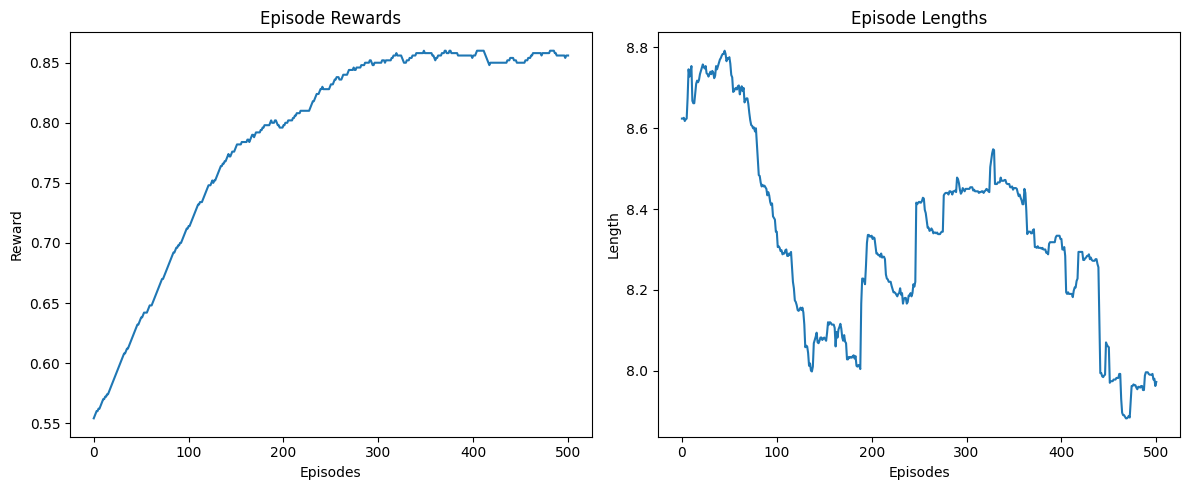

In [ ]:
from src_agents.sarsaSemiGradiente import *   


 # Fijar la semilla para reproducibilidad
seed = 1995
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
    
    # Inicializar el entorno (por ejemplo, mapa 8x8 sin deslizamiento)
env_wrapper = FrozenLakeWrapper(is_slippery=False, map_name="4x4")
state_size = env_wrapper.observation_space.n
action_size = env_wrapper.action_space.n
    
    # Crear el agente SARSA
agent = SarsaSemigrad(state_size, action_size, hidden_size=64, lr=0.001, gamma=0.99,
                       epsilon=1.0, min_epsilon=0.1, decay_rate=0.995)
    
    # Entrenar el agente SARSA
episode_rewards, episode_lengths, trained_agent = train_sarsa(env_wrapper, agent, num_episodes=1000, seed=seed)
    
    # Calcular la Q-table a partir del modelo entrenado
Q_table = np.zeros((state_size, action_size))
for s in range(state_size):
    s_one_hot = one_hot(s, state_size)
    with torch.no_grad():
        Q_table[s] = trained_agent.model(torch.FloatTensor(s_one_hot).unsqueeze(0)).numpy()[0]
policy_actions = [np.argmax(Q_table[s]) for s in range(state_size)]
print("Pol√≠tica extra√≠da (acci√≥n por estado):")
print(policy_actions)
    
    # Visualizar estad√≠sticas de entrenamiento
visualizer = GraphVisualizer(episode_rewards, episode_lengths, rolling_length=500)
visualizer.plot_all()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

def plot_all_three(list_stats, episode_lengths, Q, env, actions, window=50):
    """
    Muestra en una sola figura:
      1) Recompensa total por episodio.
      2) Longitud de los episodios (con media m√≥vil).
      3) Pol√≠tica aprendida en el entorno (flechas).

    Par√°metros:
    -----------
    list_stats : list
        Lista con las recompensas totales por episodio.
    episode_lengths : list
        Lista con la longitud (n√∫mero de pasos) de cada episodio.
    Q : np.ndarray
        Q-table con dimensiones [n_estados, n_acciones].
    env : gym.Env o wrapper
        Entorno FrozenLake (ej. FrozenLake-v1). Si es un wrapper, se acceder√° a env.env.
    actions : list[int]
        Lista de enteros (0,1,2,3) que representan la pol√≠tica escogida por el agente.
    window : int
        Tama√±o de la ventana para calcular la media m√≥vil de la longitud de episodios.
    """
    
    # Usamos el entorno interno si se trata de un wrapper
    if hasattr(env, 'env'):
        env_inner = env.env
    else:
        env_inner = env
    
    # Crear la figura con 3 subplots en una fila
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1) Recompensa total por episodio
    indices = list(range(len(list_stats)))
    ax1.plot(indices, list_stats, label="Recompensa Total", color="blue")
    ax1.set_title("Recompensa Total por Episodio")
    ax1.set_xlabel("Episodio")
    ax1.set_ylabel("Recompensa")
    ax1.grid(True)
    ax1.legend()
    
    # 2) Longitud de episodios (con media m√≥vil)
    indices = list(range(len(episode_lengths)))
    ax2.plot(indices, episode_lengths, label="Longitud de episodio", alpha=0.6, color="green")
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode="valid")
        ax2.plot(range(window-1, len(episode_lengths)), moving_avg,
                 label=f"Media M√≥vil (window={window})", color='red', linewidth=2)
    ax2.set_title("Longitud de los Episodios")
    ax2.set_xlabel("Episodio")
    ax2.set_ylabel("N√∫mero de pasos")
    ax2.grid(True)
    ax2.legend()
    
    # 3) Pol√≠tica aprendida (mapa de FrozenLake con flechas)
    arrow_dict = {0: '‚Üê', 1: '‚Üì', 2: '‚Üí', 3: '‚Üë'}
    num_filas, num_columnas = env_inner.unwrapped.desc.shape
    best_actions = [np.argmax(Q[s]) for s in range(env_inner.observation_space.n)]
    best_actions_2d = np.reshape(best_actions, (num_filas, num_columnas))
    
    ax3.set_xlim(-0.5, num_columnas - 0.5)
    ax3.set_ylim(num_filas - 0.5, -0.5)
    
    # Dibujar cada celda con su color seg√∫n el tipo
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env_inner.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                color = "gray"
            elif celda == 'G':
                color = "green"
            elif celda == 'F':
                color = "skyblue"
            elif celda == 'H':
                color = "red"
            else:
                color = "white"
            ax3.add_patch(plt.Rectangle((columna - 0.5, fila - 0.5),
                                        1, 1, color=color, ec="black"))
    
    # A√±adir texto en cada celda
    for fila in range(num_filas):
        for columna in range(num_columnas):
            celda = env_inner.unwrapped.desc[fila, columna].decode("utf-8")
            if celda == 'S':
                ax3.text(columna, fila, "Start", ha="center", va="center",
                         fontsize=12, color="white", fontweight="bold")
            elif celda in ['H', 'G']:
                ax3.text(columna, fila, celda, ha="center", va="center",
                         fontsize=14, color="white", fontweight="bold")
            else:
                accion_optima = best_actions_2d[fila, columna]
                flecha = arrow_dict.get(accion_optima, '?')
                ax3.text(columna, fila, flecha, ha="center", va="center",
                         fontsize=16, color="black", fontweight="bold")
    
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("Pol√≠tica Aprendida", pad=10)
    
    # Leyenda de flechas y colores
    left_arrow = mlines.Line2D([], [], color='black', marker=r'$\leftarrow$', 
                               linestyle='None', markersize=12, label='Acci√≥n 0: Izquierda')
    down_arrow = mlines.Line2D([], [], color='black', marker=r'$\downarrow$', 
                               linestyle='None', markersize=12, label='Acci√≥n 1: Abajo')
    right_arrow = mlines.Line2D([], [], color='black', marker=r'$\rightarrow$', 
                                linestyle='None', markersize=12, label='Acci√≥n 2: Derecha')
    up_arrow = mlines.Line2D([], [], color='black', marker=r'$\uparrow$', 
                             linestyle='None', markersize=12, label='Acci√≥n 3: Arriba')
    patch_s = mpatches.Patch(color="gray", label="S (Inicio)")
    patch_f = mpatches.Patch(color="skyblue", label="F (Hielo)")
    patch_h = mpatches.Patch(color="red", label="H (Agua)")
    patch_g = mpatches.Patch(color="green", label="G (Meta)")
    
    policy_str = str(actions)
    policy_line = mlines.Line2D([], [], color='none', marker='',
                                linestyle='None', markersize=12, label=f"\n Pol√≠tica escogida: {policy_str}")
    
    legend_handles = [left_arrow, down_arrow, right_arrow, up_arrow,
                      patch_s, patch_f, patch_h, patch_g,
                      policy_line]
    
    ax3.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
               loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()


Entrenando SARSA Semigradiente:   2%|‚ñç                     | 104/5000 [00:02<01:56, 42.10episodio/s]

Episodio 100/5000, Recompensa Promedio: 0.01, Epsilon: 0.905


Entrenando SARSA Semigradiente:   4%|‚ñâ                     | 202/5000 [00:04<01:50, 43.55episodio/s]

Episodio 200/5000, Recompensa Promedio: 0.02, Epsilon: 0.819


Entrenando SARSA Semigradiente:   6%|‚ñà‚ñé                    | 303/5000 [00:07<02:15, 34.62episodio/s]

Episodio 300/5000, Recompensa Promedio: 0.01, Epsilon: 0.741


Entrenando SARSA Semigradiente:   8%|‚ñà‚ñä                    | 403/5000 [00:10<02:41, 28.41episodio/s]

Episodio 400/5000, Recompensa Promedio: 0.03, Epsilon: 0.670


Entrenando SARSA Semigradiente:  10%|‚ñà‚ñà‚ñè                   | 505/5000 [00:13<01:49, 41.14episodio/s]

Episodio 500/5000, Recompensa Promedio: 0.05, Epsilon: 0.607


Entrenando SARSA Semigradiente:  12%|‚ñà‚ñà‚ñã                   | 608/5000 [00:16<01:49, 40.28episodio/s]

Episodio 600/5000, Recompensa Promedio: 0.19, Epsilon: 0.549


Entrenando SARSA Semigradiente:  14%|‚ñà‚ñà‚ñà                   | 704/5000 [00:18<01:24, 50.96episodio/s]

Episodio 700/5000, Recompensa Promedio: 0.54, Epsilon: 0.497


Entrenando SARSA Semigradiente:  16%|‚ñà‚ñà‚ñà‚ñå                  | 799/5000 [00:21<02:17, 30.60episodio/s]

Episodio 800/5000, Recompensa Promedio: 0.48, Epsilon: 0.449


Entrenando SARSA Semigradiente:  18%|‚ñà‚ñà‚ñà‚ñâ                  | 908/5000 [00:24<01:37, 41.99episodio/s]

Episodio 900/5000, Recompensa Promedio: 0.59, Epsilon: 0.407


Entrenando SARSA Semigradiente:  20%|‚ñà‚ñà‚ñà‚ñà‚ñè                | 1008/5000 [00:26<01:20, 49.57episodio/s]

Episodio 1000/5000, Recompensa Promedio: 0.69, Epsilon: 0.368


Entrenando SARSA Semigradiente:  22%|‚ñà‚ñà‚ñà‚ñà‚ñã                | 1103/5000 [00:28<01:37, 39.93episodio/s]

Episodio 1100/5000, Recompensa Promedio: 0.76, Epsilon: 0.333


Entrenando SARSA Semigradiente:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà                | 1205/5000 [00:30<01:22, 46.08episodio/s]

Episodio 1200/5000, Recompensa Promedio: 0.69, Epsilon: 0.301


Entrenando SARSA Semigradiente:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç               | 1308/5000 [00:33<01:19, 46.46episodio/s]

Episodio 1300/5000, Recompensa Promedio: 0.81, Epsilon: 0.273


Entrenando SARSA Semigradiente:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ               | 1404/5000 [00:35<01:25, 42.02episodio/s]

Episodio 1400/5000, Recompensa Promedio: 0.81, Epsilon: 0.247


Entrenando SARSA Semigradiente:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 1502/5000 [00:37<01:16, 45.59episodio/s]

Episodio 1500/5000, Recompensa Promedio: 0.81, Epsilon: 0.223


Entrenando SARSA Semigradiente:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä              | 1610/5000 [00:39<01:03, 53.21episodio/s]

Episodio 1600/5000, Recompensa Promedio: 0.84, Epsilon: 0.202


Entrenando SARSA Semigradiente:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 1707/5000 [00:41<01:05, 50.66episodio/s]

Episodio 1700/5000, Recompensa Promedio: 0.82, Epsilon: 0.183


Entrenando SARSA Semigradiente:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 1811/5000 [00:43<00:57, 55.16episodio/s]

Episodio 1800/5000, Recompensa Promedio: 0.84, Epsilon: 0.165


Entrenando SARSA Semigradiente:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 1908/5000 [00:45<01:07, 45.79episodio/s]

Episodio 1900/5000, Recompensa Promedio: 0.90, Epsilon: 0.150


Entrenando SARSA Semigradiente:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 2005/5000 [00:47<00:58, 51.48episodio/s]

Episodio 2000/5000, Recompensa Promedio: 0.87, Epsilon: 0.135


Entrenando SARSA Semigradiente:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 2106/5000 [00:49<00:53, 53.78episodio/s]

Episodio 2100/5000, Recompensa Promedio: 0.91, Epsilon: 0.122


Entrenando SARSA Semigradiente:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè           | 2199/5000 [00:51<00:52, 52.93episodio/s]

Episodio 2200/5000, Recompensa Promedio: 0.89, Epsilon: 0.111


Entrenando SARSA Semigradiente:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã           | 2303/5000 [00:54<01:07, 39.84episodio/s]

Episodio 2300/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 2407/5000 [00:55<00:43, 59.62episodio/s]

Episodio 2400/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 2508/5000 [00:57<00:38, 65.19episodio/s]

Episodio 2500/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 2607/5000 [00:59<00:51, 46.13episodio/s]

Episodio 2600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé         | 2708/5000 [01:01<00:37, 60.65episodio/s]

Episodio 2700/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 2804/5000 [01:03<00:49, 44.48episodio/s]

Episodio 2800/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 2909/5000 [01:05<00:36, 57.87episodio/s]

Episodio 2900/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 3007/5000 [01:07<00:35, 56.19episodio/s]

Episodio 3000/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 3104/5000 [01:09<00:43, 43.72episodio/s]

Episodio 3100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 3209/5000 [01:11<00:28, 61.88episodio/s]

Episodio 3200/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 3307/5000 [01:12<00:28, 58.53episodio/s]

Episodio 3300/5000, Recompensa Promedio: 0.95, Epsilon: 0.100


Entrenando SARSA Semigradiente:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 3406/5000 [01:14<00:30, 51.91episodio/s]

Episodio 3400/5000, Recompensa Promedio: 0.89, Epsilon: 0.100


Entrenando SARSA Semigradiente:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã      | 3505/5000 [01:16<00:29, 50.92episodio/s]

Episodio 3500/5000, Recompensa Promedio: 0.88, Epsilon: 0.100


Entrenando SARSA Semigradiente:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 3605/5000 [01:18<00:22, 62.43episodio/s]

Episodio 3600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 3708/5000 [01:20<00:21, 60.21episodio/s]

Episodio 3700/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 3806/5000 [01:22<00:18, 63.05episodio/s]

Episodio 3800/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 3906/5000 [01:23<00:19, 56.49episodio/s]

Episodio 3900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 4005/5000 [01:25<00:16, 59.13episodio/s]

Episodio 4000/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 4107/5000 [01:27<00:15, 58.09episodio/s]

Episodio 4100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4206/5000 [01:29<00:13, 59.69episodio/s]

Episodio 4200/5000, Recompensa Promedio: 0.93, Epsilon: 0.100


Entrenando SARSA Semigradiente:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 4308/5000 [01:30<00:11, 61.86episodio/s]

Episodio 4300/5000, Recompensa Promedio: 0.98, Epsilon: 0.100


Entrenando SARSA Semigradiente:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 4408/5000 [01:33<00:11, 51.41episodio/s]

Episodio 4400/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


Entrenando SARSA Semigradiente:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4505/5000 [01:34<00:08, 57.40episodio/s]

Episodio 4500/5000, Recompensa Promedio: 0.97, Epsilon: 0.100


Entrenando SARSA Semigradiente:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4608/5000 [01:36<00:06, 60.31episodio/s]

Episodio 4600/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4705/5000 [01:38<00:05, 55.02episodio/s]

Episodio 4700/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4811/5000 [01:40<00:03, 55.80episodio/s]

Episodio 4800/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4910/5000 [01:41<00:01, 55.11episodio/s]

Episodio 4900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [01:43<00:00, 48.23episodio/s]


Episodio 5000/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


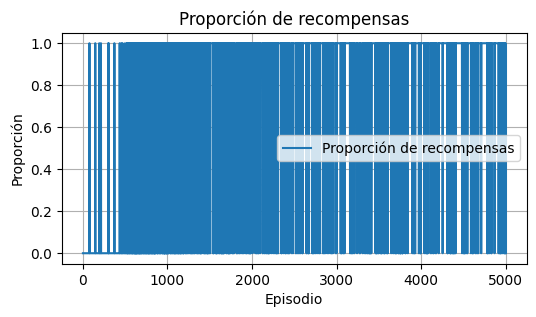

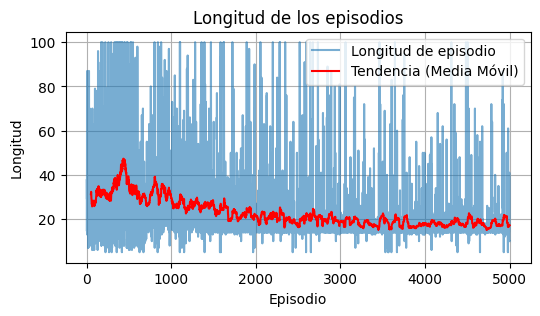

In [ ]:
# Importar las librer√≠as necesarias
import numpy as np
import random
import gymnasium as gym
import torch
from src_agents import SarsaSemigradiente, pi_star_from_Q, plot, plot_comparison

# Establecer semillas para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value) if torch.cuda.is_available() else None

# Crear el entorno
env_sarsa_sg = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

# Inicializar el agente
agente_sarsa_sg = SarsaSemigradiente(
    env=env_sarsa_sg, 
    epsilon=1.0,               # Epsilon inicial alto para exploraci√≥n
    gamma=0.99,                # Factor de descuento
    learning_rate=0.001,       # Tasa de aprendizaje para la red neuronal
    hidden_size=64,            # Tama√±o de la capa oculta
    min_epsilon=0.1,           # Valor m√≠nimo de epsilon despu√©s del decaimiento
    exploration_decay_rate=0.001,  # Tasa de decaimiento de epsilon
    seed=seed_value            # Semilla para reproducibilidad
)

# Entrenar el agente
rewards_sarsa_sg, episode_lengths_sarsa_sg = agente_sarsa_sg.entrenar(num_episodios=5000)

# Obtener la pol√≠tica √≥ptima
# Nota: La pol√≠tica √≥ptima para redes neuronales puede ser diferente a la Q-table
# Aqu√≠ construimos una Q-table a partir de las predicciones de la red
Q_sarsa_sg = np.zeros((env_sarsa_sg.observation_space.n, env_sarsa_sg.action_space.n))

for state in range(env_sarsa_sg.observation_space.n):
    # Convertir estado a one-hot
    state_one_hot = np.zeros(env_sarsa_sg.observation_space.n, dtype=np.float32)
    state_one_hot[state] = 1.0
    
    # Obtener valores Q desde la red neuronal
    state_tensor = torch.FloatTensor(state_one_hot).unsqueeze(0)
    with torch.no_grad():
        q_values = agente_sarsa_sg.model(state_tensor).numpy()[0]
    
    # Guardar valores en la Q-table
    Q_sarsa_sg[state] = q_values

# Obtener la pol√≠tica √≥ptima usando la Q-table generada
pi_star_sarsa_sg, actions_sarsa_sg = pi_star_from_Q(env_sarsa_sg, Q_sarsa_sg)

# Visualizar resultados
plot(rewards_sarsa_sg)
plot_episode_lengths(episode_lengths_sarsa_sg)

# Si quieres comparar con otros agentes
# plot_comparison([stats_mc_on_policy, rewards_sarsa_sg], 
#                ["Monte Carlo On-Policy", "SARSA Semigradiente"])

Entrenando SARSA Semigradiente:   0%|                                | 0/5000 [00:00<?, ?episodio/s]c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\RL_FJLGM\src_agents\sarsaSemiGradiente.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  objetivo = torch.tensor(objetivo)
Entrenando SARSA Semigradiente:   2%|‚ñç                     | 108/5000 [00:02<02:00, 40.66episodio/s]

Episodio 100/5000, Recompensa Promedio: 0.01, Epsilon: 0.905


Entrenando SARSA Semigradiente:   4%|‚ñâ                     | 205/5000 [00:05<02:05, 38.17episodio/s]

Episodio 200/5000, Recompensa Promedio: 0.02, Epsilon: 0.819


Entrenando SARSA Semigradiente:   6%|‚ñà‚ñé                    | 301/5000 [00:08<02:27, 31.90episodio/s]

Episodio 300/5000, Recompensa Promedio: 0.01, Epsilon: 0.741


Entrenando SARSA Semigradiente:   8%|‚ñà‚ñä                    | 404/5000 [00:11<02:50, 26.93episodio/s]

Episodio 400/5000, Recompensa Promedio: 0.03, Epsilon: 0.670


Entrenando SARSA Semigradiente:  10%|‚ñà‚ñà‚ñè                   | 509/5000 [00:15<01:48, 41.29episodio/s]

Episodio 500/5000, Recompensa Promedio: 0.05, Epsilon: 0.607


Entrenando SARSA Semigradiente:  12%|‚ñà‚ñà‚ñã                   | 603/5000 [00:17<02:07, 34.54episodio/s]

Episodio 600/5000, Recompensa Promedio: 0.19, Epsilon: 0.549


Entrenando SARSA Semigradiente:  14%|‚ñà‚ñà‚ñà                   | 708/5000 [00:20<01:34, 45.43episodio/s]

Episodio 700/5000, Recompensa Promedio: 0.54, Epsilon: 0.497


Entrenando SARSA Semigradiente:  16%|‚ñà‚ñà‚ñà‚ñå                  | 801/5000 [00:23<02:44, 25.58episodio/s]

Episodio 800/5000, Recompensa Promedio: 0.48, Epsilon: 0.449


Entrenando SARSA Semigradiente:  18%|‚ñà‚ñà‚ñà‚ñâ                  | 907/5000 [00:26<01:45, 38.89episodio/s]

Episodio 900/5000, Recompensa Promedio: 0.59, Epsilon: 0.407


Entrenando SARSA Semigradiente:  20%|‚ñà‚ñà‚ñà‚ñà‚ñè                | 1008/5000 [00:29<01:29, 44.36episodio/s]

Episodio 1000/5000, Recompensa Promedio: 0.69, Epsilon: 0.368


Entrenando SARSA Semigradiente:  22%|‚ñà‚ñà‚ñà‚ñà‚ñã                | 1102/5000 [00:31<01:46, 36.72episodio/s]

Episodio 1100/5000, Recompensa Promedio: 0.76, Epsilon: 0.333


Entrenando SARSA Semigradiente:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà                | 1204/5000 [00:33<01:30, 42.12episodio/s]

Episodio 1200/5000, Recompensa Promedio: 0.69, Epsilon: 0.301


Entrenando SARSA Semigradiente:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç               | 1307/5000 [00:36<01:24, 43.74episodio/s]

Episodio 1300/5000, Recompensa Promedio: 0.81, Epsilon: 0.273


Entrenando SARSA Semigradiente:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ               | 1406/5000 [00:38<01:32, 39.04episodio/s]

Episodio 1400/5000, Recompensa Promedio: 0.81, Epsilon: 0.247


Entrenando SARSA Semigradiente:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 1504/5000 [00:41<01:27, 40.16episodio/s]

Episodio 1500/5000, Recompensa Promedio: 0.81, Epsilon: 0.223


Entrenando SARSA Semigradiente:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã              | 1607/5000 [00:43<01:13, 45.89episodio/s]

Episodio 1600/5000, Recompensa Promedio: 0.84, Epsilon: 0.202


Entrenando SARSA Semigradiente:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 1708/5000 [00:45<01:21, 40.20episodio/s]

Episodio 1700/5000, Recompensa Promedio: 0.82, Epsilon: 0.183


Entrenando SARSA Semigradiente:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå             | 1812/5000 [00:48<01:03, 50.14episodio/s]

Episodio 1800/5000, Recompensa Promedio: 0.84, Epsilon: 0.165


Entrenando SARSA Semigradiente:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ             | 1903/5000 [00:50<01:20, 38.66episodio/s]

Episodio 1900/5000, Recompensa Promedio: 0.90, Epsilon: 0.150


Entrenando SARSA Semigradiente:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 2011/5000 [00:52<00:57, 51.82episodio/s]

Episodio 2000/5000, Recompensa Promedio: 0.87, Epsilon: 0.135


Entrenando SARSA Semigradiente:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 2108/5000 [00:54<00:56, 51.27episodio/s]

Episodio 2100/5000, Recompensa Promedio: 0.91, Epsilon: 0.122


Entrenando SARSA Semigradiente:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè           | 2200/5000 [00:56<01:05, 42.99episodio/s]

Episodio 2200/5000, Recompensa Promedio: 0.89, Epsilon: 0.111


Entrenando SARSA Semigradiente:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã           | 2308/5000 [00:59<00:55, 48.37episodio/s]

Episodio 2300/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 2407/5000 [01:00<00:45, 56.58episodio/s]

Episodio 2400/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 2507/5000 [01:02<00:40, 61.78episodio/s]

Episodio 2500/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ          | 2607/5000 [01:04<00:50, 47.06episodio/s]

Episodio 2600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé         | 2708/5000 [01:06<00:39, 57.34episodio/s]

Episodio 2700/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 2808/5000 [01:09<00:46, 47.18episodio/s]

Episodio 2800/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 2910/5000 [01:11<00:39, 53.40episodio/s]

Episodio 2900/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 3008/5000 [01:13<00:38, 51.84episodio/s]

Episodio 3000/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 3104/5000 [01:14<00:35, 53.83episodio/s]

Episodio 3100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 3204/5000 [01:16<00:32, 55.56episodio/s]

Episodio 3200/5000, Recompensa Promedio: 0.94, Epsilon: 0.100


Entrenando SARSA Semigradiente:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 3310/5000 [01:18<00:29, 57.25episodio/s]

Episodio 3300/5000, Recompensa Promedio: 0.95, Epsilon: 0.100


Entrenando SARSA Semigradiente:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé      | 3412/5000 [01:20<00:27, 58.34episodio/s]

Episodio 3400/5000, Recompensa Promedio: 0.89, Epsilon: 0.100


Entrenando SARSA Semigradiente:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã      | 3504/5000 [01:22<00:30, 49.14episodio/s]

Episodio 3500/5000, Recompensa Promedio: 0.88, Epsilon: 0.100


Entrenando SARSA Semigradiente:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 3606/5000 [01:24<00:26, 51.78episodio/s]

Episodio 3600/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 3711/5000 [01:26<00:20, 62.07episodio/s]

Episodio 3700/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 3812/5000 [01:27<00:19, 61.74episodio/s]

Episodio 3800/5000, Recompensa Promedio: 0.86, Epsilon: 0.100


Entrenando SARSA Semigradiente:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 3904/5000 [01:29<00:19, 56.42episodio/s]

Episodio 3900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 4011/5000 [01:31<00:16, 58.82episodio/s]

Episodio 4000/5000, Recompensa Promedio: 0.90, Epsilon: 0.100


Entrenando SARSA Semigradiente:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 4106/5000 [01:33<00:18, 49.17episodio/s]

Episodio 4100/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 4205/5000 [01:35<00:13, 60.07episodio/s]

Episodio 4200/5000, Recompensa Promedio: 0.93, Epsilon: 0.100


Entrenando SARSA Semigradiente:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 4306/5000 [01:36<00:12, 55.49episodio/s]

Episodio 4300/5000, Recompensa Promedio: 0.98, Epsilon: 0.100


Entrenando SARSA Semigradiente:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 4409/5000 [01:38<00:10, 55.99episodio/s]

Episodio 4400/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


Entrenando SARSA Semigradiente:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 4504/5000 [01:40<00:09, 50.18episodio/s]

Episodio 4500/5000, Recompensa Promedio: 0.97, Epsilon: 0.100


Entrenando SARSA Semigradiente:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 4608/5000 [01:42<00:06, 56.84episodio/s]

Episodio 4600/5000, Recompensa Promedio: 0.91, Epsilon: 0.100


Entrenando SARSA Semigradiente:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 4713/5000 [01:44<00:04, 62.30episodio/s]

Episodio 4700/5000, Recompensa Promedio: 0.92, Epsilon: 0.100


Entrenando SARSA Semigradiente:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 4812/5000 [01:46<00:03, 50.99episodio/s]

Episodio 4800/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 4910/5000 [01:48<00:01, 57.44episodio/s]

Episodio 4900/5000, Recompensa Promedio: 0.96, Epsilon: 0.100


Entrenando SARSA Semigradiente: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [01:50<00:00, 45.43episodio/s]


Episodio 5000/5000, Recompensa Promedio: 0.87, Epsilon: 0.100


AttributeError: 'FrozenLakeWrapper' object has no attribute 'unwrapped'

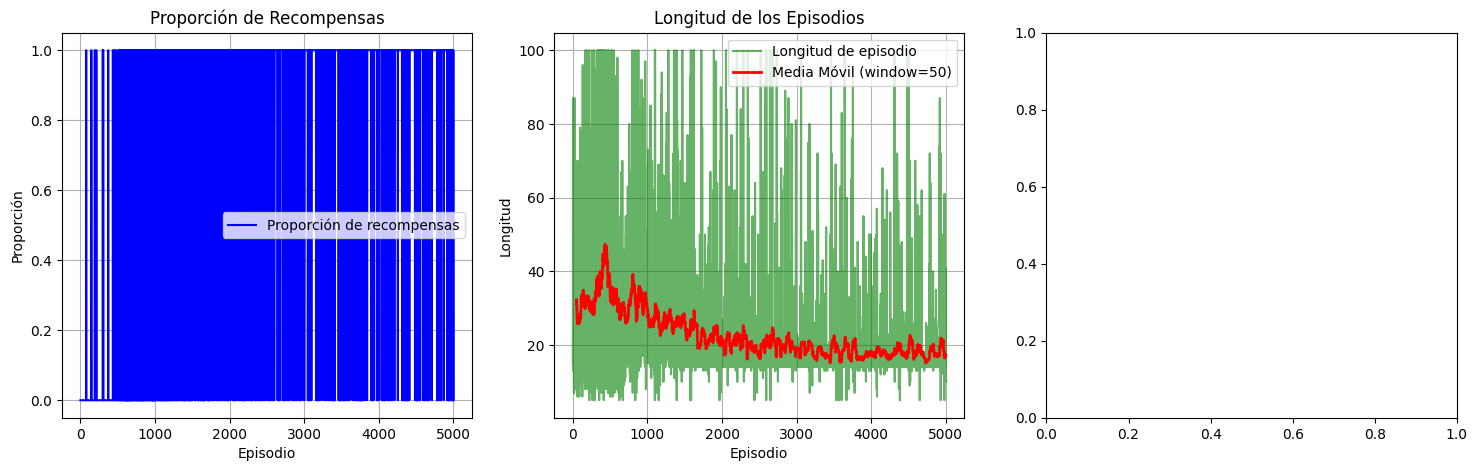

In [ ]:
import gymnasium as gym
import torch
import numpy as np
import random

from src_agents import SarsaSemigradiente, pi_star_from_Q

# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)

# Crear el entorno utilizando el wrapper (8x8, no resbaladizo)
env_wrapper = FrozenLakeWrapper(is_slippery=False, map_name="8x8")

# Obtener dimensiones del entorno
state_size = env_wrapper.observation_space.n   # Por ejemplo, 64 para un mapa 8x8
action_size = env_wrapper.action_space.n         # Normalmente 4

# Inicializar el agente SARSA semigradiente
agent = SarsaSemigradiente(
    env=env_wrapper, 
    epsilon=1.0,               # Epsilon inicial alto para exploraci√≥n
    gamma=0.99,                # Factor de descuento
    learning_rate=0.001,       # Tasa de aprendizaje para la red neuronal
    hidden_size=64,            # Tama√±o de la capa oculta
    min_epsilon=0.1,           # Valor m√≠nimo de epsilon despu√©s del decaimiento
    exploration_decay_rate=0.001,  # Tasa de decaimiento de epsilon
    seed=seed_value            # Semilla para reproducibilidad
)

# Entrenar el agente (por ejemplo, durante 5000 episodios)
num_episodios = 5000
rewards_sarsa_sg, episode_lengths_sarsa_sg = agent.entrenar(num_episodios=num_episodios)

# Construir una Q-table a partir del modelo entrenado
Q_sarsa_sg = np.zeros((state_size, action_size))
for s in range(state_size):
    state_one_hot = np.zeros(state_size, dtype=np.float32)
    state_one_hot[s] = 1.0
    with torch.no_grad():
        Q_sarsa_sg[s] = agent.model(torch.FloatTensor(state_one_hot).unsqueeze(0)).numpy()[0]

# Obtener la pol√≠tica √≥ptima a partir de la Q-table
pi_star_sarsa_sg, actions_sarsa_sg = pi_star_from_Q(env_wrapper, Q_sarsa_sg)

# Graficar los resultados utilizando plot_all_three:
plot_all_three(
    list_stats=rewards_sarsa_sg, 
    episode_lengths=episode_lengths_sarsa_sg, 
    Q=Q_sarsa_sg, 
    env=env_wrapper, 
    actions=actions_sarsa_sg, 
    window=50
)


In [ ]:
import numpy as np
import random
import gymnasium as gym
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


# Establecer semillas para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random
torch.manual_seed(seed_value)  # Establecer semilla de PyTorch

# Funci√≥n auxiliar para extraer Q-values de la red neuronal para todos los estados
def extract_Q_from_model(model, env):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))
    
    for state in range(num_states):
        # Convertir estado a tensor one-hot
        state_tensor = torch.zeros(num_states)
        state_tensor[state] = 1.0
        state_tensor = state_tensor.unsqueeze(0)  # A√±adir dimensi√≥n de batch
        
        # Obtener valores Q para el estado
        with torch.no_grad():
            q_values = model(state_tensor).squeeze(0).numpy()
        
        # Guardar valores Q
        Q[state] = q_values
    
    return Q

# Creaci√≥n del entorno
env_sarsa_sg_8x8 = gym.make("FrozenLake-v1", is_slippery=False, map_name="8x8", render_mode="ansi")

# Creaci√≥n y entrenamiento del agente Sarsa Semigradiente
agente_sarsa_sg_8x8 = SarsaSemigradiente(
    env=env_sarsa_sg_8x8, 
    epsilon=1.0, 
    gamma=0.99, 
    alpha=0.001,  # Tasa de aprendizaje m√°s baja para la red neuronal
    decay=True, 
    num_episodios=5000,
    hidden_size=64  # Tama√±o de la capa oculta
)

# Entrenamiento del agente
model_sarsa_sg_8x8, stats_sarsa_sg_8x8, episode_lengths_sarsa_sg_8x8 = agente_sarsa_sg_8x8.entrenar()

# Extraer Q-values del modelo entrenado
Q_sarsa_sg_8x8 = extract_Q_from_model(model_sarsa_sg_8x8, env_sarsa_sg_8x8)

# Obtener pol√≠tica √≥ptima a partir de los Q-values
pi_sarsa_sg_8x8, actions_sarsa_sg_8x8 = pi_star_from_Q(env_sarsa_sg_8x8, Q_sarsa_sg_8x8)





Entrenando: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5000/5000 [02:15<00:00, 36.96episodio/s]


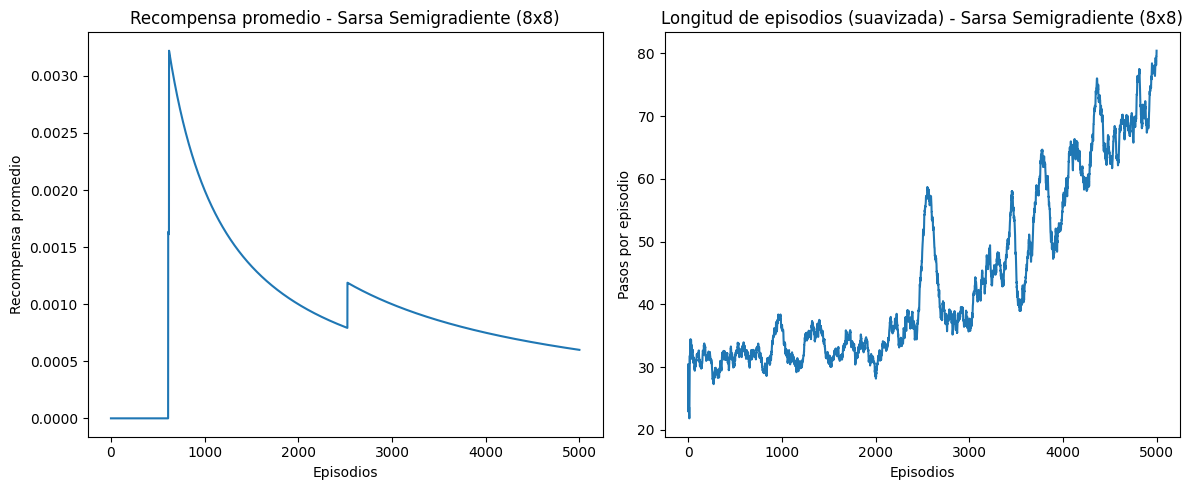

In [ ]:
# Visualizaci√≥n de resultados
plt.figure(figsize=(12, 5))

# Gr√°fico de recompensa promedio
plt.subplot(1, 2, 1)
plt.plot(stats_sarsa_sg_8x8)
plt.title('Recompensa promedio - Sarsa Semigradiente (8x8)')
plt.xlabel('Episodios')
plt.ylabel('Recompensa promedio')

# Gr√°fico de longitud de episodios
plt.subplot(1, 2, 2)
window_size = 100
episode_lengths_smoothed = [np.mean(episode_lengths_sarsa_sg_8x8[max(0, i-window_size):i+1]) 
                           for i in range(len(episode_lengths_sarsa_sg_8x8))]
plt.plot(episode_lengths_smoothed)
plt.title('Longitud de episodios (suavizada) - Sarsa Semigradiente (8x8)')
plt.xlabel('Episodios')
plt.ylabel('Pasos por episodio')

plt.tight_layout()
plt.show()

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Funci√≥n que codifica (estado, acci√≥n) en un vector one-hot
def one_hot(state, n_states, action, n_actions):
    vec = np.zeros(n_states * n_actions)
    index = state * n_actions + action
    vec[index] = 1
    return vec

# Funci√≥n Q aproximada: Q(s,a) = theta^T * phi(s,a)
def get_q(theta, state, n_states, action, n_actions):
    phi = one_hot(state, n_states, action, n_actions)
    return np.dot(theta, phi)

# Obtiene los valores Q para todas las acciones en un estado dado
def get_q_all(theta, state, n_states, n_actions):
    return np.array([get_q(theta, state, n_states, a, n_actions) for a in range(n_actions)])

# Pol√≠tica epsilon-greedy basada en la aproximaci√≥n Q
def epsilon_greedy(theta, state, n_states, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        q_values = get_q_all(theta, state, n_states, n_actions)
        return np.argmax(q_values)

# Funci√≥n de entrenamiento usando SARSA semigradiente
def train_sarsa_semigradiente(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Inicializamos los par√°metros (theta) con ceros
    theta = np.zeros(n_states * n_actions)
    rewards_per_episode = []
    
    for episode in range(num_episodes):
        # Reiniciamos el ambiente
        observation, info = env.reset()
        state = observation
        action = epsilon_greedy(theta, state, n_states, n_actions, epsilon)
        episode_reward = 0
        done = False
        
        # Se ejecuta el episodio
        while not done:
            next_obs, reward, done, truncated, info = env.step(action)
            next_state = next_obs
            episode_reward += reward
            
            # Si hemos alcanzado un estado terminal, actualizamos y rompemos
            if done:
                delta = reward - get_q(theta, state, n_states, action, n_actions)
                theta += alpha * delta * one_hot(state, n_states, action, n_actions)
                break
            else:
                next_action = epsilon_greedy(theta, next_state, n_states, n_actions, epsilon)
                # C√°lculo del error TD (delta)
                delta = reward + gamma * get_q(theta, next_state, n_states, next_action, n_actions) - get_q(theta, state, n_states, action, n_actions)
                # Actualizaci√≥n semigradiente
                theta += alpha * delta * one_hot(state, n_states, action, n_actions)
                state = next_state
                action = next_action
        
        rewards_per_episode.append(episode_reward)
    
    return theta, rewards_per_episode

# Funci√≥n para evaluar la pol√≠tica obtenida (usando selecci√≥n greedy)
def evaluate_policy(env, theta, n_episodes=100, epsilon=0.0):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    rewards = []
    
    for episode in range(n_episodes):
        observation, info = env.reset()
        state = observation
        episode_reward = 0
        done = False
        
        while not done:
            action = epsilon_greedy(theta, state, n_states, n_actions, epsilon)
            next_obs, reward, done, truncated, info = env.step(action)
            state = next_obs
            episode_reward += reward
            if done:
                break
        rewards.append(episode_reward)
    
    return np.mean(rewards)

# Ejecuci√≥n principal
if __name__ == "__main__":
    # Creamos el ambiente FrozenLake (modo determinista para facilitar el entrenamiento)
    env = gym.make("FrozenLake-v1", is_slippery=False)
    
    # Par√°metros de entrenamiento
    num_episodes = 1000
    alpha = 0.1
    gamma = 0.99
    epsilon = 0.1
    
    # Entrenamos con SARSA semigradiente
    theta, rewards = train_sarsa_semigradiente(env, num_episodes, alpha, gamma, epsilon)
    
    # Evaluamos la pol√≠tica aprendida
    avg_reward = evaluate_policy(env, theta, n_episodes=100)
    print("Recompensa promedio en 100 episodios de evaluaci√≥n:", avg_reward)
    
    # Graficamos la evoluci√≥n de la recompensa durante el entrenamiento
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title("Recompensa por episodio durante el entrenamiento")
    plt.show()


KeyboardInterrupt: 